In [1]:
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True   
sess = tf.Session(config=config)
KTF.set_session(sess)

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import keras
import numpy as np
from toyNet import ToyNet
from synthetic_data import get_data
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
tf.set_random_seed(9988)
np.random.seed(9988)

Using TensorFlow backend.


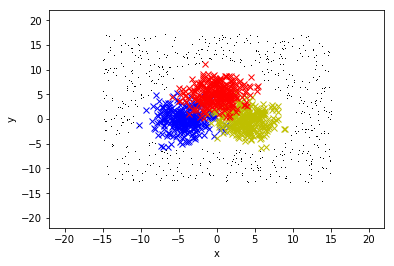

In [2]:
######################### get data and visualize the in-domain data points ##############
x_train, y_train = get_data()

In [3]:
########################################### Loss function for DPN- models ####################################
def fn_minus(correct, predicted):
    y_max = (tf.reduce_max(correct, axis=1) -0.5) #-----------------> only change here
    y_sgm = tf.nn.sigmoid(predicted)
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted) \
            - y_max*tf.reduce_mean(y_sgm, axis=1)
    

########################################### Loss function for DPN+ models ####################################
def fn_plus(correct, predicted):
    y_max = (tf.reduce_max(correct, axis=1) +0.5) #-----------------> only change here
    y_sgm = tf.nn.sigmoid(predicted)
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted) \
            - y_max*tf.reduce_mean(y_sgm, axis=1)

########################################### Loss function for DPN-rkl models ####################################
def construct_KL_cost(target_alpha, alpha, epsilon=1e-8):
    
    target_precision = tf.reduce_sum(target_alpha, axis=1, keep_dims=True)
    precision = tf.reduce_sum(alpha, axis=1, keep_dims=True)
    
    cost = tf.lgamma(target_precision + epsilon) - tf.lgamma(precision + epsilon) \
           + tf.reduce_sum(
        tf.lgamma(alpha + epsilon) - tf.lgamma(target_alpha + epsilon), axis=1) \
           + tf.reduce_sum((target_alpha - alpha) * (
    tf.digamma(target_alpha + epsilon) -
    tf.digamma(target_precision + epsilon)), axis=1)
    cost = tf.reduce_mean(cost)
    
    return cost

#%%
def fn_rkl(correct, predicted):

    pred_alpha = tf.exp(predicted)
    rkl_loss = construct_KL_cost(pred_alpha, correct)

    return rkl_loss

In [4]:
################ plot function for DPN model ###############

from uncertainty_metric import differential_entropy, entropy, maxP, mutual_info
import matplotlib.pyplot as plt

def plot_images(model):

    my_set = np.empty([1,2])

    for i in np.arange(-20, 20, 0.2):
        for j in np.arange(-20, 20, 0.2):
            my_set = np.concatenate((my_set, [[i,j]]), axis=0)

    logits = model.predict(my_set)
    logits = logits.astype('float64')


    max_p = maxP(logits)
    ent = entropy(logits)
    d_ent = differential_entropy(logits)
    precision = np.sum(np.exp(logits/100), axis=1)
    mi = mutual_info(logits)
    
    fig, axs = plt.subplots(1, 5,  figsize=(15, 4))
    axs[0].set_title(" Max Prob.", size=15)
    maxP_img = axs[0].scatter(my_set[:, 0], my_set[:, 1], c= max_p)
    fig.colorbar(maxP_img, ax=axs[0])

    axs[1].set_title(" Entropy", size=15)
    ent_img = axs[1].scatter(my_set[:, 0], my_set[:, 1], c= ent)
    fig.colorbar(ent_img, ax=axs[1])

    axs[2].set_title(" Mutual Info.", size=15)
    ent_img = axs[2].scatter(my_set[:, 0], my_set[:, 1], c= mi)
    fig.colorbar(ent_img, ax=axs[2])

    axs[3].set_title(" Precision (Inverse-EPKL)", size=15)
    precision_img = axs[3].scatter(my_set[:, 0], my_set[:, 1], c= precision)
    fig.colorbar(precision_img, ax=axs[3])

    axs[4].set_title(" Diff. Entropy", size=15)
    d_ent_img = axs[4].scatter(my_set[:, 0], my_set[:, 1], c= d_ent)
    fig.colorbar(d_ent_img, ax=axs[4])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 125)               375       
_________________________________________________________________
dense_2 (Dense)              (None, 125)               15750     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 378       
Total params: 16,503
Trainable params: 16,503
Non-trainable params: 0
_________________________________________________________________
Finished compiling
Fitting the model .......... 
Done training ...model_minus 


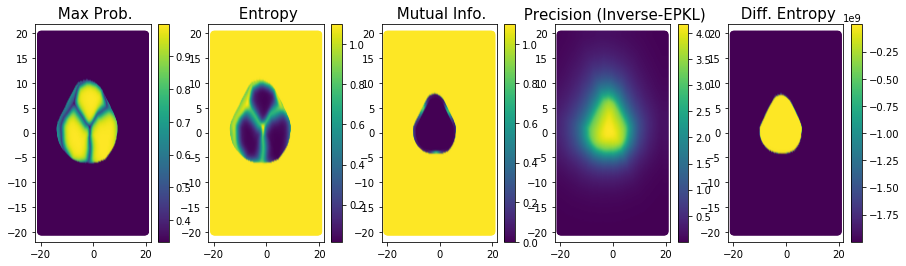

In [5]:
######################################## DPN- model ##########################
model_minus = ToyNet()
model_minus.summary()
opt = keras.optimizers.SGD(lr= 0.01, momentum= 0.9, nesterov= True)
model_minus.compile(loss=fn_minus, optimizer=opt, metrics=["accuracy"])
print("Finished compiling")

####################
# Network training #
####################
print("Fitting the model .......... ")
model_minus.fit(x_train, y_train, batch_size= 1200, epochs=2500, verbose=0)
print("Done training ...model_minus ")

################### visualization for DPN- #################
plot_images(model_minus)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 125)               375       
_________________________________________________________________
dense_5 (Dense)              (None, 125)               15750     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 378       
Total params: 16,503
Trainable params: 16,503
Non-trainable params: 0
_________________________________________________________________
Finished compiling
Fitting the model .......... 
Done training ...model_plus 


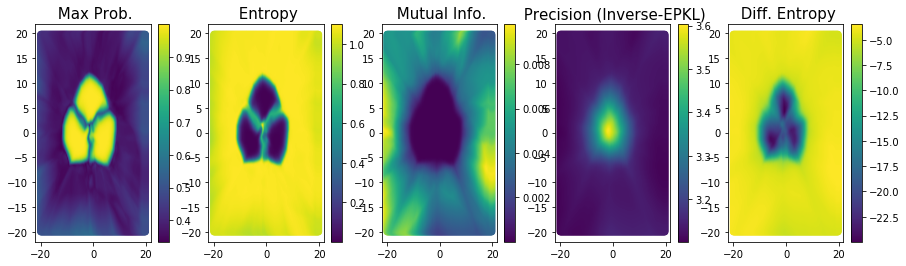

In [6]:
######################################## DPN+ model ##########################
model_plus = ToyNet()
model_plus.summary()
opt = keras.optimizers.SGD(lr= 0.03, momentum= 0.9, nesterov= True)
model_plus.compile(loss=fn_plus, optimizer=opt, metrics=["accuracy"])
print("Finished compiling")

####################
# Network training #
####################
print("Fitting the model .......... ")
model_plus.fit(x_train, y_train, batch_size= 1200, epochs=2500, verbose=0)
print("Done training ...model_plus ")

################### visualization for DPN+ #################
plot_images(model_plus)